In [1]:
# 训练一个图片分类器
# 我们将按顺序做以下步骤：

# 通过torchvision加载CIFAR10里面的训练和测试数据集，并对数据进行标准化
# 定义卷积神经网络
# 定义损失函数
# 利用训练数据训练网络
# 利用测试数据测试网络

In [1]:
# 1.加载并标准化CIFAR10
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)

testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)

classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# 输出图像的函数
def imshow(img):
    img=img/2+0.5
    npimg=img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show

  cat plane truck horse


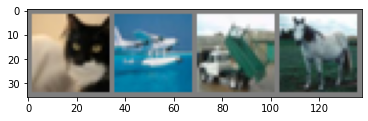

In [5]:
# 随机获取训练图片
dataiter=iter(trainloader)
images,labels=dataiter.next()

# 显示图片
imshow(torchvision.utils.make_grid(images))

#打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:
# 2.定义一个卷积神经网络
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(3,6,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)
        self.fc1=nn.Linear(16*5*5,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,10)
    
    def forward(self,x):
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,16*5*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x
net=Net()


In [8]:
# 3.定义损失函数和优化器
# 使用多分类的交叉熵损失函数和随机梯度下降优化器(使用 momentum ）
import torch.optim as optim

criterion=nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(),lr=0.001,momentum=0.9)


In [10]:
#  4.训练网络 
for epoch in range(2):
    running_loss=0.0
    for i,data in enumerate(trainloader,0):
        #get the inputs
        inputs, labels =data

        #zero the parameter gradients
        optimizer.zero_grad()

        # forward+backward+optimize
        outputs=net(inputs)
        loss =criterion(outputs,labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss +=loss.item()
        if i% 2000==1999:
            print('[%d,%5d]:%.3f'%(epoch +1,i+1,running_loss/2000))
            running_loss=0.0
print('Finished Training')

[1, 2000]:2.200
[1, 4000]:1.828
[1, 6000]:1.636
[1, 8000]:1.577
[1,10000]:1.533
[1,12000]:1.475
[2, 2000]:1.391
[2, 4000]:1.374
[2, 6000]:1.356
[2, 8000]:1.330
[2,10000]:1.310
[2,12000]:1.305
Finished Training


In [11]:
# 保存已训练得到的模型
PATH='./cifar_net_cat_plane_truck_horse.pth'
torch.save(net.state_dict(),PATH)

GroundTruth:   cat  ship  ship plane


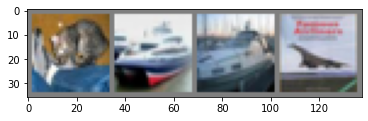

In [12]:
# 5.使用测试数据测试网络
# 第一步。让我们展示测试集中的图像来熟悉一下。
dataiter=iter(testloader)
images,labels=dataiter.next()

# 输出图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s'% classes[labels[j]] for j in range(4)))

In [13]:
# 让我们加载保存的模型（注意：在这里保存和加载模型不是必要的，我们只是为了解释如何去做这件事）
net =Net()
net.load_state_dict(torch.load(PATH))
# 输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引
outputs=net(images)
_,predicted=torch.max(outputs,1)

print('Predicted',' '.join('%5s'%classes[predicted[j]] for j in range(4)))

Predicted  bird   car  ship plane


In [19]:
# 网络在整个数据集上表现
correct=0
total=0
with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        

print('Accuracy of the network on the 10000 test images: %d%%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53%


In [25]:
# 那么哪些是表现好的类呢？哪些是表现的差的类呢
class_correct=list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images,labels=data
        outputs=net(images)
        _,predicted=torch.max(outputs,1)
        c=(predicted==labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label]+=c[i].item()
            class_total[label]+=1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 37 %
Accuracy of   car : 81 %
Accuracy of  bird : 45 %
Accuracy of   cat : 37 %
Accuracy of  deer : 40 %
Accuracy of   dog : 42 %
Accuracy of  frog : 57 %
Accuracy of horse : 61 %
Accuracy of  ship : 84 %
Accuracy of truck : 43 %


In [38]:
import torch.utils.data
from torch.autograd import Variable 
dummy_input=images
print(dummy_input.size())

torch.Size([4, 3, 32, 32])


In [39]:
input_names=['input']
output_names=['output']
torch_out = torch.onnx._export(net, dummy_input, "./cifar_net_cat_plane_truck_horse.onnx",verbose=True, input_names=input_names, output_names=output_names)

graph(%input : Float(4:3072, 3:1024, 32:32, 32:1, requires_grad=0, device=cpu),
      %1 : Float(6:75, 3:25, 5:5, 5:1, requires_grad=1, device=cpu),
      %2 : Float(6:1, requires_grad=1, device=cpu),
      %3 : Float(16:150, 6:25, 5:5, 5:1, requires_grad=1, device=cpu),
      %4 : Float(16:1, requires_grad=1, device=cpu),
      %5 : Float(120:400, 400:1, requires_grad=1, device=cpu),
      %6 : Float(120:1, requires_grad=1, device=cpu),
      %7 : Float(84:120, 120:1, requires_grad=1, device=cpu),
      %8 : Float(84:1, requires_grad=1, device=cpu),
      %9 : Float(10:84, 84:1, requires_grad=1, device=cpu),
      %10 : Float(10:1, requires_grad=1, device=cpu)):
  %11 : Float(4:4704, 6:784, 28:28, 28:1, requires_grad=1, device=cpu) = onnx::Conv[dilations=[1, 1], group=1, kernel_shape=[5, 5], pads=[0, 0, 0, 0], strides=[1, 1]](%input, %1, %2) # /Users/smart/opt/anaconda3/envs/py3/lib/python3.8/site-packages/torch/nn/modules/conv.py:419:0
  %12 : Float(4:4704, 6:784, 28:28, 28:1, requir